In [1]:
# prompt: Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [5]:
BASE_PATH = '/content/drive/MyDrive/Face Recognition'
MODEL_PATH = f'{BASE_PATH}/alexnet_face_recognition.h5'
model = keras.models.load_model(MODEL_PATH)

# Reconstruct your label map (must match training-time order)
label_map = {idx: name for name, idx in
             zip(sorted(os.listdir(f'{BASE_PATH}/Augmented')),
                 range(len(os.listdir(f'{BASE_PATH}/Augmented'))))}

In [8]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode

def capture_frame():
    # Show a live camera feed in the notebook and return a single frame as an OpenCV array
    js = Javascript('''
    async function captureImage() {
      const video = document.createElement('video');
      video.style.display = 'none';
      document.body.appendChild(video);
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();
      // Draw to canvas
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      // Stop stream
      stream.getTracks().forEach(track => track.stop());
      const dataUrl = canvas.toDataURL('image/jpeg');
      return dataUrl;
    }
    captureImage();
    ''')
    # Pass the string data of the Javascript object to eval_js
    data_url = eval_js(js.data)
    # Decode base64 image
    header, encoded = data_url.split(',', 1)
    data = b64decode(encoded)
    # Convert to numpy array and decode with OpenCV
    arr = np.frombuffer(data, np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    return img

# Test capture
frame = capture_frame()
print(frame.shape)  # e.g. (480, 640, 3)

(480, 640, 3)


In [9]:
# Load OpenCV’s pretrained face detector
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)

# Compute mean image from training (reload or store earlier)
mean_img = np.load(f'{BASE_PATH}/mean_image.npy')  # you can save during training

def preprocess_face(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    if len(faces) == 0:
        return None  # no face
    # take largest
    x, y, w, h = max(faces, key=lambda b: b[2]*b[3])
    face = img_bgr[y:y+h, x:x+w]
    face = cv2.resize(face, (227, 227))
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = face.astype('float32') - mean_img
    return face, (x, y, w, h)


Stopped.


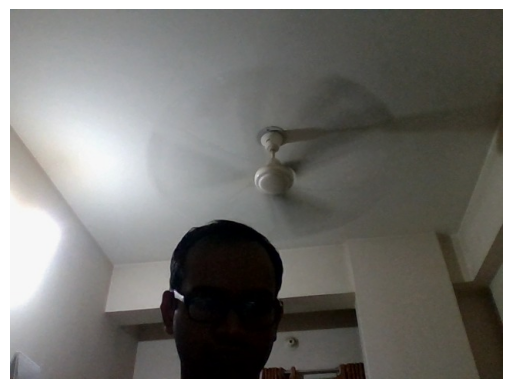

In [12]:
import time
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

try:
    while True:
        frame = capture_frame()  # BGR
        result = preprocess_face(frame)
        if result is not None:
            face, (x, y, w, h) = result
            inp = np.expand_dims(face, axis=0)  # (1,227,227,3)
            preds = model.predict(inp)
            label_idx = np.argmax(preds[0])
            prob = preds[0][label_idx]
            label = label_map[label_idx] if prob > 0.5 else "Unknown"

            # Draw rectangle and label
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
            cv2.putText(frame, f'{label} ({prob:.2f})',
                        (x, y-10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.9, (0,255,0), 2)
        # Show frame
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)
        plt.imshow(rgb)
        plt.axis('off')
        display(plt.gcf())
        time.sleep(0.1)  # adjust for fps

except KeyboardInterrupt:
    print("Stopped.")
